### 할당된 GPU 확인

In [1]:
!nvidia-smi

Tue Jun 15 03:37:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Drive mount

In [2]:
from google.colab import drive
import os, sys

drive.mount('/content/drive')

Mounted at /content/drive


### 필요한 library 및 자료 다운로드

In [3]:
!pip install  mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

     |████████████████████████████████| 46.9MB 119kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 5.3MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595704 sha256=edefa6556ecd1353d1277391e789c2cabffd66b01cb3193fbc54d19f89fb27be
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.2MB 5.2MB/s 
     |████████████████████████████████| 2.3MB 6.2MB/s 
     |████████████████████████████████| 3.3MB 26.2MB/s 
     |████████████████████████████████| 901kB 39.2MB/s 


In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [5]:
from transformers import AdamW, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup

### gpu 사용

In [6]:
##GPU 사용 시
device = torch.device("cuda:0")

### Pretrained bert, vocab load

In [7]:
#bertmodel, vocab = get_pytorch_kobert_model()
#bertmodel = get_kobert_model()

model_path = '/content/drive/MyDrive/kobert_from_pretrained'
vocab_file = '/content/drive/MyDrive/kobert_news_wiki_ko_cased-1087f8699e.spiece'
bertmodel = BertModel.from_pretrained(model_path)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file, padding_token='[PAD]')

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

### 우리가 사용하는 dataset 가져와서 train, validation, test set으로 분류

In [9]:
file1 = '/content/drive/MyDrive/problem_ner_multilabel_re_addonlykorean_replacevariable_replacenumber.csv'
file3 = '/content/drive/MyDrive/ner_preprocessed_complete_re_drop_addonlykorean_replacevariable_replacenumber_8_label_single.csv'

In [10]:
df = pd.read_csv(file3)

### tag가 string이기 때문에 숫자로 바꾸기 위해서 encoder라는 것을 사용한다
### encoder를 사용하면 쉽게 tag의 문자를 숫자로 바꿔준다

In [11]:
#라벨의 숫자화
label = df['tag'].values
encoder = LabelEncoder()
encoder.fit(label)

LabelEncoder()

### label별 data 개수가 불균형한 경우 학습에 영향을 주기 때문에 loss 가중치를 조정하여 해결할 수도 있다
### 우리 학습할 땐 사용 안했음

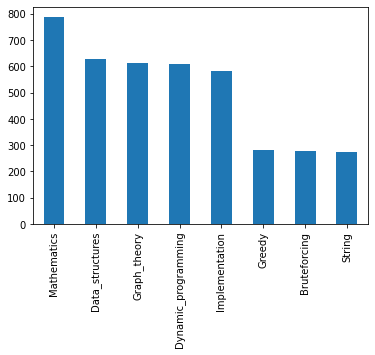

['Bruteforcing' 'Data_structures' 'Dynamic_programming' 'Graph_theory'
 'Greedy' 'Implementation' 'Mathematics' 'String']
tensor([1.8255, 0.8068, 0.8333, 0.8279, 1.7933, 0.8690, 0.6440, 1.8388])


In [12]:
df.tag.value_counts().plot(kind='bar')
plt.show()

class_loss = [df.tag.value_counts()[i] for i in encoder.classes_ ]
class_weights = compute_class_weight('balanced', np.unique(df['tag']), df['tag'])
weights= torch.tensor(class_weights,dtype=torch.float)
print(encoder.classes_)
print(weights)

In [13]:
### 분류한 dataset을 형식에 맞게 변환하는 코드

In [14]:
def set_data(dataframe) :
  dataset = []
  tmp = encoder.transform(dataframe['tag'])
  i = 0
  for index, row in dataframe.iterrows():
   problem = row['desc_variabel_renumber_0']
   if not pd.isna(row['input_variabel_renumber_0']) :
      problem = problem + row['input_variabel_renumber_0']

   dataset.append([problem , tmp[i]])
   i = i + 1
  return dataset

In [15]:
dataset = set_data(df)

### tokenizer는 문장을 단어로 나눠주는 역할을 한다

In [16]:
#tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(vocab_file, vocab, lower=False)

### 데이터셋 관련 코드

In [17]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


### model parameter


In [18]:
## Setting parameters
max_len = 512
batch_size = 32

### 데이터 셋 표준화 과정

In [19]:
data_all = BERTDataset(dataset, 0, 1, tok, max_len, True, False)

In [20]:
dataloader = torch.utils.data.DataLoader(data_all, batch_size=batch_size, num_workers=4)

### 우리가 사용할 모델 정의 
### bert 모델 뒤에 single layer 추가해서 softmax로 분류하는 방식

In [21]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
   
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)

        return pooler

### model 할당

In [22]:
model = BERTClassifier(bertmodel, num_classes=8, dr_rate=0.0).to(device) 

In [23]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [24]:
output = []

with torch.no_grad():
  model.eval()
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    output.extend(out.to('cpu').tolist())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [25]:
df['vector'] = output

In [49]:
train_df, remaining = train_test_split(df, random_state = 46, train_size = 0.7)
valid_df, test_df = train_test_split(remaining, random_state=46, train_size = 0.5)

In [50]:
def set_data_vector(dataframe) :
  dataset = []
  tmp = encoder.transform(dataframe['tag'])
  i = 0
  for index, row in dataframe.iterrows():
   dataset.append([torch.tensor(row['vector']) , tmp[i]])
   i = i + 1
  return dataset

In [51]:
data_train = set_data_vector(train_df)
data_valid = set_data_vector(valid_df)
data_test = set_data_vector(test_df)

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=4)

In [80]:
class Classifier(nn.Module):
    def __init__(self,
                 hidden_size = 768,
                 num_classes=11,
                 dr_rate=0.0):
       super(Classifier, self).__init__()
       self.second_size = 384
       self.linear_relu_stack = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
       )
       self.mp = nn.MaxPool1d(2, stride= 2)
       self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(self.second_size, self.second_size),
            nn.ReLU(),
            nn.Linear(self.second_size, self.second_size),
            nn.ReLU()
       )
       self.classication = nn.Linear(self.second_size, num_classes)

    def forward(self, x) :
      tmp = self.linear_relu_stack(x)
      tmp = tmp.unsqueeze(1)
      tmp2 = self.mp(tmp)
      out = self.linear_relu_stack2(tmp2)
      
      return self.classication(out).squeeze()

In [81]:
net = Classifier(num_classes=8, dr_rate = 0.1).to(device) 

In [82]:
warmup_ratio = 0.1
num_epochs = 40
max_grad_norm = 1
log_interval = 100
learning_rate =  1e-4 #5e-5

In [83]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in net.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01}, #0.01
    {'params': [p for n, p in net.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0} #0.0
]

In [84]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(weight = weights).to(device)

In [85]:
t_total = len(dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [86]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [87]:
train_loss_values = []
validation_loss_values = [] 
train_acc_list = []
validation_acc_list = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    validation_loss = 0.0

    net.train()
    for batch_id, (vector, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        vector = vector.to(device)
        label = label.long().to(device)
        out = net(vector)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_loss += loss.item()
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(train_loss)
    train_acc_list.append(train_acc / len(train_dataloader))

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    net.eval()
    for batch_id, (vector, label) in enumerate(tqdm_notebook(valid_dataloader)):
        vector = vector.to(device)
        label = label.long().to(device)
        out = net.forward(vector).reshape(-1, 8)
        loss = loss_fn(out, label)
        
        validation_loss += loss.item() 
        test_acc += calc_accuracy(out, label)
    print("epoch {} validation acc {}".format(e+1, test_acc / (batch_id+1)))
    validation_loss = validation_loss / len(valid_dataloader)
    validation_loss_values.append(validation_loss)
    validation_acc_list.append(test_acc / len(valid_dataloader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


epoch 1 batch id 1 loss 2.090517282485962 train acc 0.03125

epoch 1 train acc 0.07300669835782196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 validation acc 0.0609375


epoch 2 batch id 1 loss 2.0864758491516113 train acc 0.03125

epoch 2 train acc 0.1420159896283492



epoch 2 validation acc 0.1328125


epoch 3 batch id 1 loss 2.078522205352783 train acc 0.125

epoch 3 train acc 0.17739844425237683



epoch 3 validation acc 0.2140625


epoch 4 batch id 1 loss 2.0628976821899414 train acc 0.34375

epoch 4 train acc 0.2112683664649957



epoch 4 validation acc 0.2296875


epoch 5 batch id 1 loss 2.0178613662719727 train acc 0.40625

epoch 5 train acc 0.22574546240276577



epoch 5 validation acc 0.2


epoch 6 batch id 1 loss 1.9571691751480103 train acc 0.3125

epoch 6 train acc 0.22355769230769232



epoch 6 validation acc 0.2328125


epoch 7 batch id 1 loss 1.9150909185409546 train acc 0.4375

epoch 7 train acc 0.2324168107173725



epoch 7 validation acc 0.25625


epoch 8 batch id 1 loss 1.891714334487915 train acc 0.3125

epoch 8 train acc 0.2320656871218669



epoch 8 validation acc 0.2578125


epoch 9 batch id 1 loss 1.882994294166565 train acc 0.3125

epoch 9 train acc 0.23908815903197925



epoch 9 validation acc 0.2515625


epoch 10 batch id 1 loss 1.8718340396881104 train acc 0.3125

epoch 10 train acc 0.2418971477960242



epoch 10 validation acc 0.25


epoch 11 batch id 1 loss 1.8578983545303345 train acc 0.28125

epoch 11 train acc 0.2486495246326707



epoch 11 validation acc 0.26875


epoch 12 batch id 1 loss 1.8423304557800293 train acc 0.34375

epoch 12 train acc 0.26628673292999133



epoch 12 validation acc 0.26875


epoch 13 batch id 1 loss 1.8477901220321655 train acc 0.375

epoch 13 train acc 0.2764693171996543



epoch 13 validation acc 0.284375


epoch 14 batch id 1 loss 1.8523612022399902 train acc 0.40625

epoch 14 train acc 0.28684096802074327



epoch 14 validation acc 0.2875


epoch 15 batch id 1 loss 1.8414027690887451 train acc 0.3125

epoch 15 train acc 0.2917566983578219



epoch 15 validation acc 0.29375


epoch 16 batch id 1 loss 1.8313881158828735 train acc 0.28125

epoch 16 train acc 0.29842804667242867



epoch 16 validation acc 0.296875


epoch 17 batch id 1 loss 1.8196762800216675 train acc 0.28125

epoch 17 train acc 0.30404602420051857



epoch 17 validation acc 0.2953125


epoch 18 batch id 1 loss 1.8034292459487915 train acc 0.3125

epoch 18 train acc 0.3075572601555748



epoch 18 validation acc 0.296875


epoch 19 batch id 1 loss 1.784690022468567 train acc 0.34375

epoch 19 train acc 0.3058016421780467



epoch 19 validation acc 0.290625


epoch 20 batch id 1 loss 1.776884913444519 train acc 0.3125

epoch 20 train acc 0.3075572601555748



epoch 20 validation acc 0.2984375


epoch 21 batch id 1 loss 1.7563155889511108 train acc 0.3125

epoch 21 train acc 0.3111495246326707



epoch 21 validation acc 0.2953125


epoch 22 batch id 1 loss 1.7421475648880005 train acc 0.40625

epoch 22 train acc 0.31992761452031115



epoch 22 validation acc 0.2953125


epoch 23 batch id 1 loss 1.730938196182251 train acc 0.40625

epoch 23 train acc 0.3244922212618842



epoch 23 validation acc 0.2828125


epoch 24 batch id 1 loss 1.7224071025848389 train acc 0.40625

epoch 24 train acc 0.32414109766637855



epoch 24 validation acc 0.290625


epoch 25 batch id 1 loss 1.708465337753296 train acc 0.40625

epoch 25 train acc 0.3244922212618842



epoch 25 validation acc 0.2890625


epoch 26 batch id 1 loss 1.6973302364349365 train acc 0.40625

epoch 26 train acc 0.328354580812446



epoch 26 validation acc 0.2921875


epoch 27 batch id 1 loss 1.6865214109420776 train acc 0.40625

epoch 27 train acc 0.3322169403630078



epoch 27 validation acc 0.2921875


epoch 28 batch id 1 loss 1.6760241985321045 train acc 0.40625

epoch 28 train acc 0.3343236819360415



epoch 28 validation acc 0.296875


epoch 29 batch id 1 loss 1.6703261137008667 train acc 0.40625

epoch 29 train acc 0.33572817631806395



epoch 29 validation acc 0.3


epoch 30 batch id 1 loss 1.6752394437789917 train acc 0.375

epoch 30 train acc 0.33713267070008646



epoch 30 validation acc 0.3


epoch 31 batch id 1 loss 1.6816054582595825 train acc 0.375

epoch 31 train acc 0.33713267070008646



epoch 31 validation acc 0.3


epoch 32 batch id 1 loss 1.688204288482666 train acc 0.375

epoch 32 train acc 0.33783491789109765



epoch 32 validation acc 0.3


epoch 33 batch id 1 loss 1.6925032138824463 train acc 0.34375

epoch 33 train acc 0.33826707000864303



epoch 33 validation acc 0.2921875


epoch 34 batch id 1 loss 1.6830283403396606 train acc 0.40625

epoch 34 train acc 0.3428316767502161



epoch 34 validation acc 0.29375


epoch 35 batch id 1 loss 1.6887149810791016 train acc 0.40625

epoch 35 train acc 0.3481795592048401



epoch 35 validation acc 0.3


epoch 36 batch id 1 loss 1.705602765083313 train acc 0.4375

epoch 36 train acc 0.3499351771823682



epoch 36 validation acc 0.30625


epoch 37 batch id 1 loss 1.7254210710525513 train acc 0.40625

epoch 37 train acc 0.3523930423509075



epoch 37 validation acc 0.30625


epoch 38 batch id 1 loss 1.7421627044677734 train acc 0.375

epoch 38 train acc 0.35555315471045806



epoch 38 validation acc 0.3046875


epoch 39 batch id 1 loss 1.7523980140686035 train acc 0.375

epoch 39 train acc 0.3605499135695765



epoch 39 validation acc 0.3


epoch 40 batch id 1 loss 1.743225336074829 train acc 0.375

epoch 40 train acc 0.3580110198789974



epoch 40 validation acc 0.296875


###loss, accuracy graph

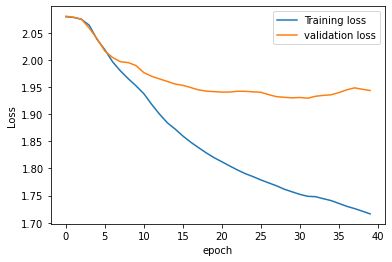

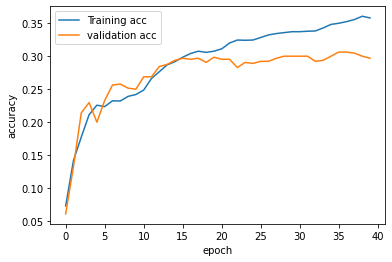

In [88]:
plt.plot(np.array(train_loss_values), label='Training loss')
plt.plot(np.array(validation_loss_values), label='validation loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(np.array(train_acc_list), label='Training acc')
plt.plot(np.array(validation_acc_list), label='validation acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [90]:
pred_list = []
test_label = []

with torch.no_grad():
  net.eval()
  for batch_id, (vector, label) in enumerate(tqdm_notebook(test_dataloader)):
    vector = vector.to(device)
    label = label.long().to(device)
    test_label.extend(label)
    out = net(vector).reshape(-1, 8)
    _, pred_value = torch.max(out, 1)
    pred_list.extend(pred_value.cpu().numpy())

pred_list = [a.squeeze().tolist() for a in pred_list]
test_label = [a.squeeze().tolist() for a in test_label]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [91]:
target_name = encoder.classes_
print(classification_report(test_label, pred_list, target_names=target_name, zero_division = 0))

                     precision    recall  f1-score   support

       Bruteforcing       0.17      0.19      0.18        53
    Data_structures       0.42      0.31      0.36        94
Dynamic_programming       0.00      0.00      0.00        71
       Graph_theory       0.41      0.43      0.42       100
             Greedy       0.11      0.18      0.13        34
     Implementation       0.25      0.30      0.27        86
        Mathematics       0.44      0.36      0.39       120
             String       0.35      0.76      0.48        51

           accuracy                           0.32       609
          macro avg       0.27      0.32      0.28       609
       weighted avg       0.30      0.32      0.30       609



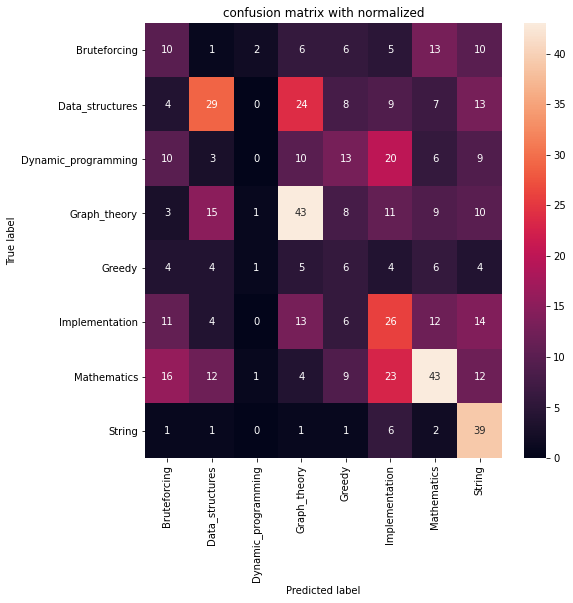

In [93]:
cm = confusion_matrix(test_label, pred_list)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, target_name, target_name)
plt.figure(figsize=(8, 8))
plt.title('confusion matrix with normalized')
sn.heatmap(df_cm, annot = True)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()